<a href="https://colab.research.google.com/github/prasadanvekar/elvtrdocs/blob/main/Bonus_Assignment_Predicting_Apple_Inc_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install the Yahoo finance package and pmdarima package
!pip install yfinance pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.0 MB/s eta 0:00:00


In [3]:
# Install Tensorflow package
!pip install tensorflow

[*********************100%%**********************]  1 of 1 completed


                Close
Date                 
2016-01-04  26.337500
2016-01-05  25.677500
2016-01-06  25.174999
2016-01-07  24.112499
2016-01-08  24.240000
2025
2024
(1619, 1, 1)
(405, 1, 1)
Epoch 1/100
51/51 [==============================] - 4s 5ms/step - loss: 0.0883
Epoch 2/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 4/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 5/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 6/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 7/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 10/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 11/1

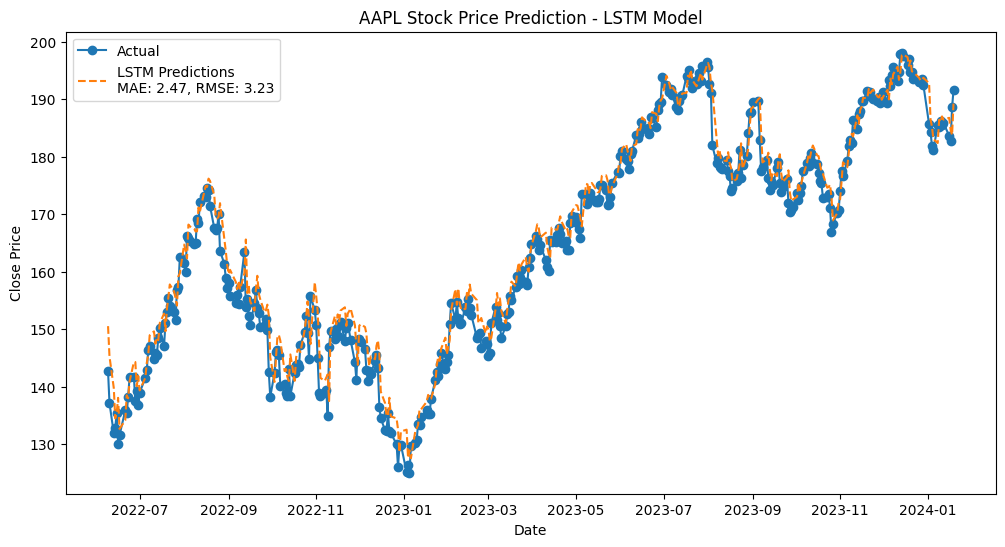

-------Raw Data-------
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.977480  270597600
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.376617  223164000
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.919146  273829600
2016-01-07  24.670000  25.032499  24.107500  24.112499  21.951853  324377600
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.067926  283192000
-------Engineered Data-------
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.977480  270597600   
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.376617  223164000   
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.919146  273829600   
2016-01-

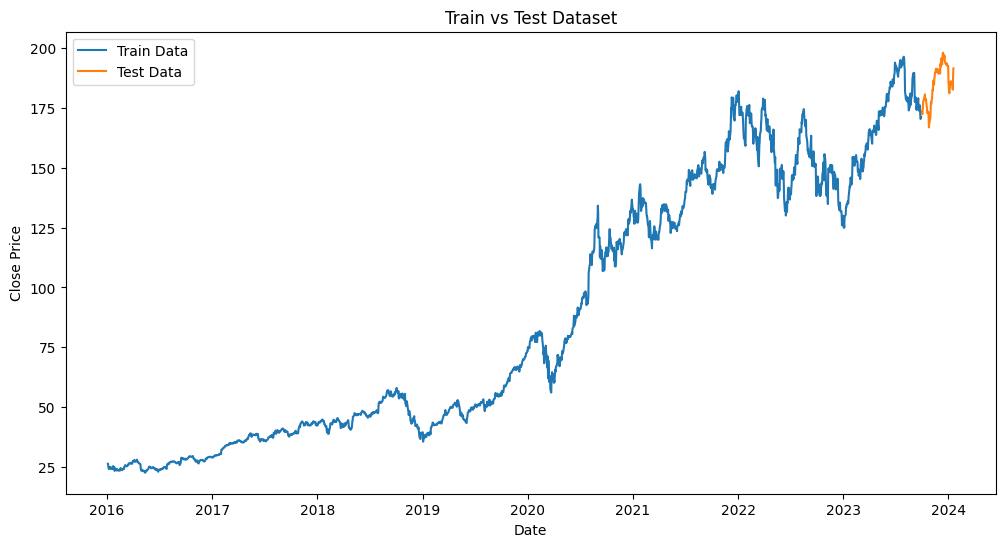

Linear Regression Metrics:
MAE: 2.78
MSE: 11.79
RMSE: 3.43

Exponential Smoothing Metrics:
MAE: 11.15
MSE: 166.39
RMSE: 12.90

LSTM Metrics:
MAE: 2.47
RMSE: 3.23

ARIMA Model Metrics:
MAE: 11.35
MSE: 171.65
RMSE: 13.10


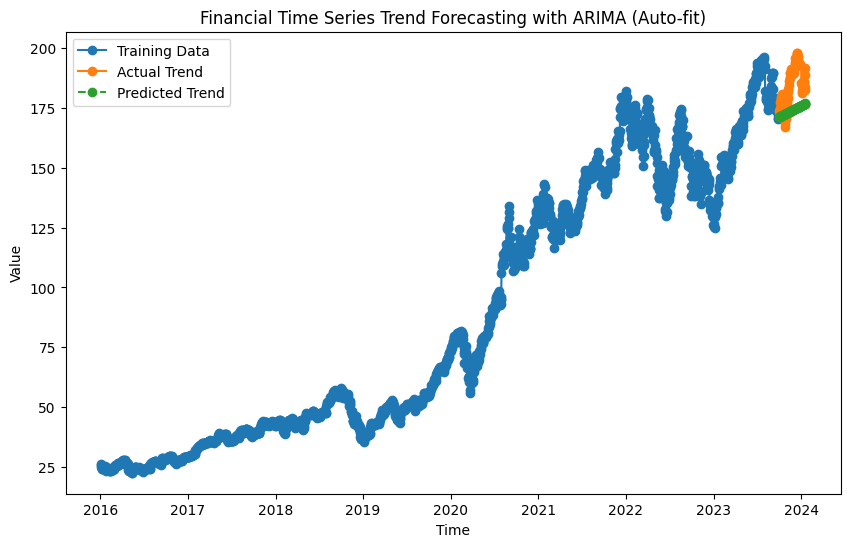

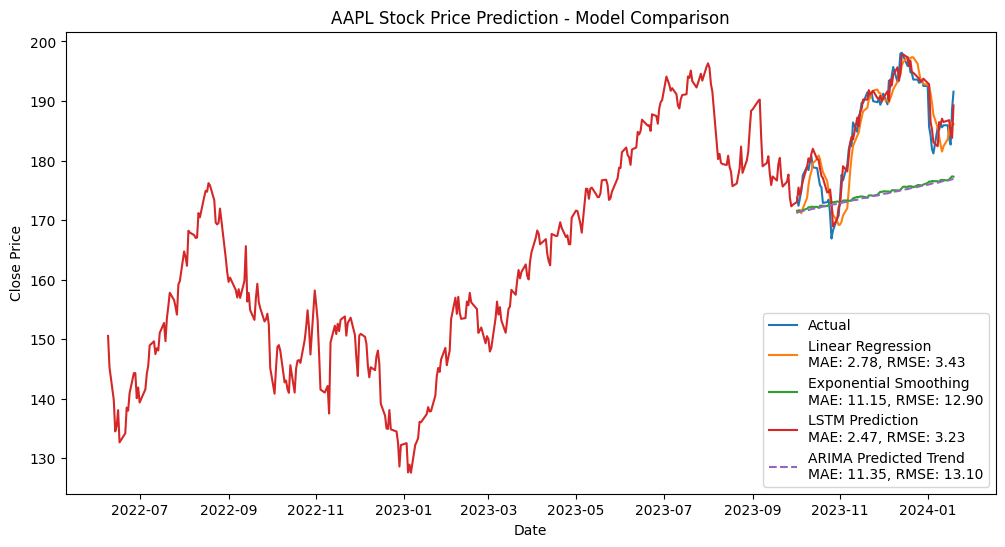

In [5]:
#################################################################################
# Bonus Assignment Objective:Build an LSTM model to predict the closing prices  #
#of Apple Inc. (AAPL) stock and compare it to the models in the core assignment.#
# Author:  Prasad S Anvekar                                                     #
# Date:  22 Jan 2024                                                            #
#################################################################################
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

# Data Acquisition
ticker = 'AAPL'
stock_data = yf.download('AAPL', start='2016-01-01', end='2024-01-21')
stock_data.sort_index(ascending=True, inplace=True)

# Data Preprocessing for LSTM Model.
# Using only the 'Close' prices
data = stock_data[['Close']]

print(data.head())

# Normalizing the data.Changing the values of numeric columns in the dataset
# to a common scale, which helps the performance of our model

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print(len(data_scaled))

# Prepare data for LSTM - need to input data in the form of 3D array.
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1 # Reducing the timesteps to 1 improved the accuracy of the model.
X, y = create_dataset(data_scaled, time_steps)

print(len(X))

# Train-test split for LSTM model
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

print(X_train_lstm.shape)
print(X_test_lstm.shape)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32)

# Predictions
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluation metrics for LSTM
lstm_mae = mean_absolute_error(y_test_original, y_pred)
lstm_mse = mean_squared_error(y_test_original, y_pred)
lstm_rmse = np.sqrt(lstm_mse)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_original):], y_test_original, label='Actual', marker='o')
plt.plot(data.index[-len(y_test_original):], y_pred, label=f'LSTM Predictions\nMAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}', linestyle='--')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction - LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Data prep for Linear Regression
# Ensure proper DatetimeIndex with frequency for time series analysis
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B', method='ffill')

print('-------Raw Data-------')
print(stock_data.head())

# Calculate rolling averages
stock_data['7_day_avg'] = stock_data['Close'].rolling(window=7, min_periods=1).mean()
stock_data['30_day_avg'] = stock_data['Close'].rolling(window=10, min_periods=1).mean()

print('-------Engineered Data-------')
print(stock_data.head())
print(stock_data.describe())

# Feature engineering
stock_data['7_day_shifted'] = stock_data['7_day_avg'].shift(1)
stock_data['30_day_shifted'] = stock_data['30_day_avg'].shift(1)

# Split the data into training and test sets
split_date = pd.to_datetime('2023-10-01')
train = stock_data.loc[stock_data.index < split_date]
test = stock_data.loc[stock_data.index >= split_date]

# Prepare the training and test data for Linear Regression
X_train = train[['7_day_shifted','30_day_shifted']].dropna()
y_train = train['Close'][1:].values
X_test = test[['7_day_shifted','30_day_shifted']].dropna()
y_test = test['Close']

# Review is the data size
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Visualization of Train and Test Datasets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Train Data')
plt.plot(test.index, test['Close'], label='Test Data')
plt.title('Train vs Test Dataset')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Fit a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict the trend for the test set
reg_predictions = model_lr.predict(X_test)

# Exponential Smoothing model

window_size = 12
exp_model = ExponentialSmoothing(train['Close'], trend='add', seasonal='add', seasonal_periods=window_size)
exp_fit = exp_model.fit()
exp_predictions = exp_fit.forecast(len(test))

# Evaluation metrics
reg_mae = mean_absolute_error(y_test, reg_predictions)
reg_mse = mean_squared_error(y_test, reg_predictions)
reg_rmse = np.sqrt(reg_mse)

exp_mae = mean_absolute_error(y_test, exp_predictions)
exp_mse = mean_squared_error(y_test, exp_predictions)
exp_rmse = np.sqrt(exp_mse)

# Performance metrics
print(f'Linear Regression Metrics:\nMAE: {reg_mae:.2f}\nMSE: {reg_mse:.2f}\nRMSE: {reg_rmse:.2f}')
print(f'\nExponential Smoothing Metrics:\nMAE: {exp_mae:.2f}\nMSE: {exp_mse:.2f}\nRMSE: {exp_rmse:.2f}')
print(f'\nLSTM Metrics:\nMAE: {lstm_mae:.2f}\nRMSE: {lstm_rmse:.2f}')

# Auto-fit ARIMA model
auto_model = auto_arima(train['Close'], seasonal=False, suppress_warnings=True)
fit_model = auto_model.fit(train['Close'])

# Forecast the trend for the test set
forecast = fit_model.predict(n_periods=len(test))

# Calculate performance metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'\nARIMA Model Metrics:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}')

# Plot the actual and predicted trends
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close'], label='Training Data', marker='o')
plt.plot(test.index, test['Close'], label='Actual Trend', marker='o')
plt.plot(test.index, forecast, label='Predicted Trend', linestyle='--', marker='o')
plt.title('Financial Time Series Trend Forecasting with ARIMA (Auto-fit)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, reg_predictions, label=f'Linear Regression\nMAE: {reg_mae:.2f}, RMSE: {reg_rmse:.2f}')
plt.plot(test.index, exp_predictions, label=f'Exponential Smoothing\nMAE: {exp_mae:.2f}, RMSE: {exp_rmse:.2f}')
plt.plot(data.index[-len(y_test_original):], y_pred, label=f'LSTM Prediction\nMAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}')
plt.plot(test.index, forecast, label=f'ARIMA Predicted Trend\nMAE: {mae:.2f}, RMSE: {rmse:.2f}', linestyle='--')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()
